In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import svm
from Utils import GeoUtils

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

%matplotlib inline

In [53]:
def getDistance(real, predict):
    lat1 = real[:,0]
    lon1 = real[:,1]
    lat2 = predict[:,0]
    lon2 = predict[:,1]

    return np.array(GeoUtils.GeoUtils.distanceInKm(lat1, lon1,lat2, lon2))

In [54]:
data = pd.read_csv("Dados/LocTreino_Equipe_4.csv")

bts_data = pd.read_csv("Dados/dados_BTSs.csv")

data.drop_duplicates(inplace=True)
data.shape
#data = data.drop(['pontoId'], axis=1)
data['taBTS2'] = data['taBTS2'].fillna(data['taBTS2'].mean())
data['taBTS4'] = data['taBTS4'].fillna(data['taBTS4'].mean())

data.describe()

,pontoId,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.0000
mean,1471.292667,-8.070097,-34.894814,116.654370,119.101165,123.863545,115.814052,121.320526,125.656192,0.663333,1.008733,2.525333,1.099388,1.093333,1.0560
std,849.057388,0.004232,0.004354,15.229664,12.666188,9.031316,12.414620,12.552702,13.134365,0.698317,0.863886,0.967117,1.954747,0.856998,0.6692
min,2.000000,-8.077570,-34.906830,86.256667,77.256667,88.340000,84.056667,79.523333,89.856667,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000
25%,746.750000,-8.073197,-34.897387,106.827500,111.673333,119.190000,106.583750,112.823333,116.077500,0.000000,0.000000,2.000000,0.000000,0.000000,1.0000
50%,1464.500000,-8.069940,-34.895346,117.156667,120.690000,124.273333,116.273333,122.840000,128.756667,1.000000,1.000000,3.000000,1.000000,1.000000,1.0000
75%,2190.250000,-8.067113,-34.891169,124.790000,128.808750,130.117083,125.590000,130.423333,135.996250,1.000000,1.000000,3.000000,1.000000,2.000000,2.0000
max,2955.000000,-8.059339,-34.885067,476.882449,144.890000,145.890000,145.423333,146.890000,150.123333,3.000000,11.090452,5.000000,38.747484,3.000000,2.0000


In [55]:
x = data.drop(['lat', 'lon', 'pontoId'], axis=1)

transformerX = StandardScaler().fit(x)
x_scaled = transformerX.transform(x)
x.describe()

,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.0000
mean,116.654370,119.101165,123.863545,115.814052,121.320526,125.656192,0.663333,1.008733,2.525333,1.099388,1.093333,1.0560
std,15.229664,12.666188,9.031316,12.414620,12.552702,13.134365,0.698317,0.863886,0.967117,1.954747,0.856998,0.6692
min,86.256667,77.256667,88.340000,84.056667,79.523333,89.856667,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000
25%,106.827500,111.673333,119.190000,106.583750,112.823333,116.077500,0.000000,0.000000,2.000000,0.000000,0.000000,1.0000
50%,117.156667,120.690000,124.273333,116.273333,122.840000,128.756667,1.000000,1.000000,3.000000,1.000000,1.000000,1.0000
75%,124.790000,128.808750,130.117083,125.590000,130.423333,135.996250,1.000000,1.000000,3.000000,1.000000,2.000000,2.0000
max,476.882449,144.890000,145.890000,145.423333,146.890000,150.123333,3.000000,11.090452,5.000000,38.747484,3.000000,2.0000


In [56]:
y = pd.DataFrame(columns=['distBTS1', 'distBTS2', 'distBTS3', 'distBTS4', 'distBTS5', 'distBTS6'])

bts1_coord = np.tile(bts_data[['lat', 'lon']].iloc[0].values, (1500,1))
y['distBTS1'] = getDistance(data[['lat', 'lon']].values, bts1_coord) 

bts2_coord = np.tile(bts_data[['lat', 'lon']].iloc[1].values, (1500,1))
y['distBTS2'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

bts3_coord = np.tile(bts_data[['lat', 'lon']].iloc[2].values, (1500,1))
y['distBTS3'] = getDistance(data[['lat', 'lon']].values, bts3_coord) 

bts4_coord = np.tile(bts_data[['lat', 'lon']].iloc[3].values, (1500,1))
y['distBTS4'] = getDistance(data[['lat', 'lon']].values, bts4_coord) 

bts5_coord = np.tile(bts_data[['lat', 'lon']].iloc[4].values, (1500,1))
y['distBTS5'] = getDistance(data[['lat', 'lon']].values, bts5_coord) 

bts6_coord = np.tile(bts_data[['lat', 'lon']].iloc[5].values, (1500,1))
y['distBTS6'] = getDistance(data[['lat', 'lon']].values, bts6_coord) 

y.head()

,distBTS1,distBTS2,distBTS3,distBTS4,distBTS5,distBTS6
0,0.879576,0.191390,1.294424,0.191390,1.291290,1.219177
1,0.665594,0.395403,1.309441,0.395403,1.103513,0.952860
2,0.629140,0.408747,1.339021,0.408747,1.067447,0.919427
3,1.026196,0.716060,0.883794,0.716060,1.471446,1.172785
4,0.793764,1.621548,2.642108,1.621548,0.390252,0.716741


In [57]:
transformerY = StandardScaler().fit(y)
y_scaled = transformerY.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

invX = transformerX.inverse_transform
invY = transformerY.inverse_transform

(1350, 12) (150, 12) (1350, 6) (150, 6)


In [58]:
knn = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3))
knn.fit(X_train, y_train)

knnreal = invY(y_test)
knnpredict = invY(knn.predict(X_test))

print (np.mean((knnpredict - knnreal)**2, axis=0))

print (np.std((knnpredict - knnreal)**2, axis=0))

[0.0012632  0.00146633 0.00122966 0.00146633 0.00141779 0.00216219]
[0.00349558 0.00439183 0.0035761  0.00439183 0.00335566 0.00757289]


In [ ]:
# kridge = MultiOutputRegressor(KernelRidge(alpha=0.6, kernel='polynomial', degree=4, coef0=1.5))
# kridge.fit(X_train, y_train)

# kridgereal = invY(y_test)
# kridgepredict = invY(kridge.predict(X_test))

# #print(getDistance(kridgereal, kridgepredict).mean())
# print (np.mean((kridgereal - kridgepredict)**2, axis=0))

In [ ]:
# gboost = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
#                                    max_depth=50, max_features='sqrt',
#                                    min_samples_leaf=5, min_samples_split=10, 
#                                    loss='huber', random_state =5))
# gboost.fit(X_train, y_train)

# gboostreal = invY(y_test)
# gboostpredict = invY(gboost.predict(X_test))

# print (np.mean((gboostreal - gboostpredict)**2, axis=0))

In [ ]:
# svr = svm.SVR()
# regr = MultiOutputRegressor(svr)
# regr.fit(X_train,y_train)

# svmreal = invY(y_test)
# svmpredict = invY(regr.predict(X_test))

# print (np.mean((svmreal - svmpredict)**2, axis=0))

In [27]:
# lasso = MultiOutputRegressor(Lasso(alpha =0.0005, random_state=1))
# lasso.fit(X_train, y_train)

# lassoreal = invY(y_test)
# lassopredict = invY(lasso.predict(X_test))

# print (np.mean((lassoreal - lassopredict)**2, axis=0))

In [59]:
bts1_coord = np.tile(bts_data[['lat', 'lon']].iloc[0].values, (1500,1))
data['distBTS1'] = getDistance(data[['lat', 'lon']].values, bts1_coord) 

bts2_coord = np.tile(bts_data[['lat', 'lon']].iloc[1].values, (1500,1))
data['distBTS2'] = getDistance(data[['lat', 'lon']].values, bts2_coord) 

bts3_coord = np.tile(bts_data[['lat', 'lon']].iloc[2].values, (1500,1))
data['distBTS3'] = getDistance(data[['lat', 'lon']].values, bts3_coord) 

bts4_coord = np.tile(bts_data[['lat', 'lon']].iloc[3].values, (1500,1))
data['distBTS4'] = getDistance(data[['lat', 'lon']].values, bts4_coord) 

bts5_coord = np.tile(bts_data[['lat', 'lon']].iloc[4].values, (1500,1))
data['distBTS5'] = getDistance(data[['lat', 'lon']].values, bts5_coord) 

bts6_coord = np.tile(bts_data[['lat', 'lon']].iloc[5].values, (1500,1))
data['distBTS6'] = getDistance(data[['lat', 'lon']].values, bts6_coord) 

x2 = data.drop(['lat', 'lon'], axis=1)
x2.describe()

,pontoId,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6,distBTS1,distBTS2,distBTS3,distBTS4,distBTS5,distBTS6
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,1471.292667,116.654370,119.101165,123.863545,115.814052,121.320526,125.656192,0.663333,1.008733,2.525333,1.099388,1.093333,1.0560,0.651671,0.824295,1.673787,0.824295,0.894737,0.836718
std,849.057388,15.229664,12.666188,9.031316,12.414620,12.552702,13.134365,0.698317,0.863886,0.967117,1.954747,0.856998,0.6692,0.338396,0.429586,0.489971,0.429586,0.451967,0.348651
min,2.000000,86.256667,77.256667,88.340000,84.056667,79.523333,89.856667,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000,0.054158,0.009910,0.870120,0.009910,0.026198,0.031430
25%,746.750000,106.827500,111.673333,119.190000,106.583750,112.823333,116.077500,0.000000,0.000000,2.000000,0.000000,0.000000,1.0000,0.372980,0.527395,1.314656,0.527395,0.476412,0.591253
50%,1464.500000,117.156667,120.690000,124.273333,116.273333,122.840000,128.756667,1.000000,1.000000,3.000000,1.000000,1.000000,1.0000,0.603009,0.760281,1.669549,0.760281,0.858269,0.811690
75%,2190.250000,124.790000,128.808750,130.117083,125.590000,130.423333,135.996250,1.000000,1.000000,3.000000,1.000000,2.000000,2.0000,0.901601,1.023290,1.989360,1.023290,1.289275,1.097895
max,2955.000000,476.882449,144.890000,145.890000,145.423333,146.890000,150.123333,3.000000,11.090452,5.000000,38.747484,3.000000,2.0000,1.847645,2.274950,2.835246,2.274950,2.053067,1.527323


In [60]:
y2 = data[['lat', 'lon']]
y2.describe()

,lat,lon
count,1500.000000,1500.000000
mean,-8.070097,-34.894814
std,0.004232,0.004354
min,-8.077570,-34.906830
25%,-8.073197,-34.897387
50%,-8.069940,-34.895346
75%,-8.067113,-34.891169
max,-8.059339,-34.885067


In [61]:
# transformerY2 = StandardScaler().fit(y2)
# y2_scaled = transformerY2.transform(y2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.1)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

# invX2 = transformerX2.inverse_transform
# invY2 = transformerY2.inverse_transform
X_test2.head()

(1350, 19) (150, 19) (1350, 2) (150, 2)


,pontoId,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6,distBTS1,distBTS2,distBTS3,distBTS4,distBTS5,distBTS6
774,832,118.790000,121.823333,127.623333,127.356667,141.256667,134.490000,1,1.0,1,1.0,2,2,1.003248,0.745882,0.900174,0.745882,1.447199,1.131198
141,1810,100.390000,117.923333,121.656667,110.523333,117.090000,103.323333,1,1.0,2,1.0,2,1,0.789707,0.957935,1.210948,0.957935,1.195058,0.760058
142,2758,121.456667,131.990000,132.823333,134.156667,128.156667,131.456667,1,2.0,4,2.0,0,1,0.688806,1.515716,2.546961,1.515716,0.287137,0.643696
1333,2038,114.490000,112.690000,124.990000,99.990000,125.490000,104.440000,1,1.0,2,1.0,2,1,0.714912,0.972897,1.308813,0.972897,1.108625,0.662330
1064,2768,128.090000,138.823333,138.723333,138.990000,137.790000,144.090000,1,3.0,5,3.0,0,1,0.873677,1.647636,2.763250,1.647636,0.429751,0.889882


In [62]:
x_aux = pd.DataFrame()
x_aux = X_test2.drop(['distBTS1', 'distBTS2', 'distBTS3', 'distBTS4', 'distBTS5', 'distBTS6', 'pontoId'], axis=1)
predicts = invY(knn.predict(transformerX.transform(x_aux.values)))
X_test2[['distBTS1', 'distBTS2', 'distBTS3', 'distBTS4', 'distBTS5', 'distBTS6']] = predicts
X_test2.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,pontoId,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6,distBTS1,distBTS2,distBTS3,distBTS4,distBTS5,distBTS6
774,832,118.790000,121.823333,127.623333,127.356667,141.256667,134.490000,1,1.0,1,1.0,2,2,1.022278,0.720994,0.887572,0.720994,1.467191,1.165711
141,1810,100.390000,117.923333,121.656667,110.523333,117.090000,103.323333,1,1.0,2,1.0,2,1,0.763422,0.932967,1.225151,0.932966,1.171860,0.747296
142,2758,121.456667,131.990000,132.823333,134.156667,128.156667,131.456667,1,2.0,4,2.0,0,1,0.650012,1.476600,2.511830,1.476600,0.250807,0.620503
1333,2038,114.490000,112.690000,124.990000,99.990000,125.490000,104.440000,1,1.0,2,1.0,2,1,0.731736,0.986523,1.300249,0.986523,1.123689,0.672004
1064,2768,128.090000,138.823333,138.723333,138.990000,137.790000,144.090000,1,3.0,5,3.0,0,1,0.871774,1.650593,2.758741,1.650593,0.429476,0.879945


In [95]:
trans_X = StandardScaler().fit(x2.drop(['pontoId'], axis=1))
X_train2_scaled = trans_X.transform(X_train2.drop(['pontoId'], axis=1))
X_test2_scaled = trans_X.transform(X_test2.drop(['pontoId'], axis=1))

trans_Y = StandardScaler().fit(y2)

y_train2 = trans_Y.transform(y_train2)
y_test2 = trans_Y.transform(y_test2)

invY2 = trans_Y.inverse_transform
invX2 = trans_X.inverse_transform

knn2 = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=3))
knn2.fit(X_train2_scaled, y_train2)

knn2real = invY2(y_test2)
start = time.time()
knn2predict = invY2(knn2.predict(X_test2_scaled))
end = time.time()
print(end - start)
print(getDistance(knn2real, knn2predict).mean())

0.007483959197998047
8.20828834529411


In [83]:
print(getDistance(knn2real, knn2predict).std())
print(getDistance(knn2real, knn2predict).min())
print(getDistance(knn2real, knn2predict).max())

0.036289452250289296
0.00034961812039152243
0.18300648460912472


(150, 2)


(array([21., 22., 16., 21., 15.,  9.,  3.,  6., 11.,  2.,  3.,  4.,  4.,
         2.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,
         2.,  1.,  0.,  1.]),
 array([  0.34961812,   6.43818034,  12.52674255,  18.61530477,
         24.70386699,  30.7924292 ,  36.88099142,  42.96955363,
         49.05811585,  55.14667807,  61.23524028,  67.3238025 ,
         73.41236472,  79.50092693,  85.58948915,  91.67805136,
         97.76661358, 103.8551758 , 109.94373801, 116.03230023,
        122.12086245, 128.20942466, 134.29798688, 140.3865491 ,
        146.47511131, 152.56367353, 158.65223574, 164.74079796,
        170.82936018, 176.91792239, 183.00648461]),
 <a list of 30 Patch objects>)

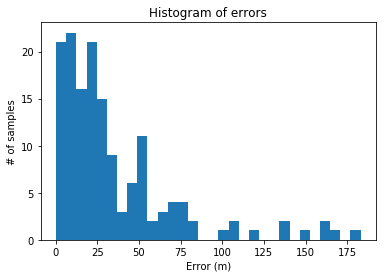

In [68]:
plt.title('Histogram of errors')
plt.ylabel('# of samples')
plt.xlabel('Error (m)')

print(kridgepredict.shape)

plt.hist(getDistance(knn2real, knn2predict)*1000, 30)

In [64]:
gboost = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=50, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5))
gboost.fit(X_train2, y_train2)

gboostreal = invY2(y_test2)
gboostpredict = invY2(gboost.predict(X_test2))

print(getDistance(gboostreal, gboostpredict).mean())

0.023863433229552537


In [ ]:
svr = svm.SVR()
regr = MultiOutputRegressor(svr)
regr.fit(X_train2,y_train2)

svmreal = invY2(y_test2)
svmpredict = invY2(regr.predict(X_test2))

print(getDistance(svmreal, svmpredict).mean())

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
multioutputregressor = MultiOutputRegressor(model_xgb).fit(X_train2, y_train2)

realoutp = invY2(multioutputregressor.predict(X_test2))
realoutr = invY2(y_test2)                                         

print(getDistance(realoutr, realoutp).mean())

In [94]:
import time
kridge = MultiOutputRegressor(KernelRidge(alpha=0.6, kernel='polynomial', degree=4, coef0=2.5))
kridge.fit(X_train2_scaled, y_train2)
kridgereal = invY2(y_test2)
start = time.time()
kridgepredict = invY2(kridge.predict(X_test2_scaled))
end = time.time()
print(end - start)
print(getDistance(kridgereal, kridgepredict).mean())

0.012847900390625
0.027502873717066924


In [84]:
print(getDistance(kridgereal, kridgepredict).std())
print(getDistance(kridgereal, kridgepredict).min())
print(getDistance(kridgereal, kridgepredict).max())

0.029518681917235487
0.00046078000068779893
0.12830832004013992


(150, 2)


(array([29., 16., 24., 14.,  3.,  6., 13.,  5.,  2.,  8.,  4.,  0.,  1.,
         3.,  5.,  1.,  2.,  0.,  1.,  1.,  1.,  2.,  1.,  2.,  2.,  0.,
         2.,  0.,  0.,  2.]),
 array([  0.46078   ,   4.72236467,   8.98394934,  13.245534  ,
         17.50711867,  21.76870334,  26.03028801,  30.29187268,
         34.55345734,  38.81504201,  43.07662668,  47.33821135,
         51.59979602,  55.86138068,  60.12296535,  64.38455002,
         68.64613469,  72.90771936,  77.16930402,  81.43088869,
         85.69247336,  89.95405803,  94.2156427 ,  98.47722736,
        102.73881203, 107.0003967 , 111.26198137, 115.52356604,
        119.7851507 , 124.04673537, 128.30832004]),
 <a list of 30 Patch objects>)

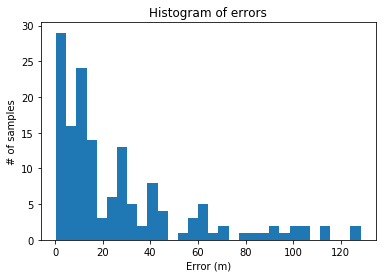

In [66]:
plt.title('Histogram of errors')
plt.ylabel('# of samples')
plt.xlabel('Error (m)')

print(kridgepredict.shape)

plt.hist(getDistance(kridgereal, kridgepredict)*1000, 30)

(150,)
(150,)
(150,)


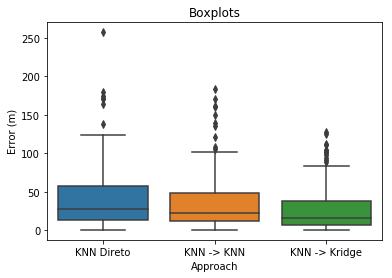

In [82]:
knnonly_errors = np.load('knn_distances.npy')
print(knnonly_errors.shape)
print(knnknn_errors.shape)
print(knnkrdg_errors.shape)
knnknn_errors = getDistance(knn2real, knn2predict)*1000
knnkrdg_errors = getDistance(kridgereal, kridgepredict)*1000

allerrors = []

allerrors.extend(knnonly_errors)
allerrors.extend(knnknn_errors)
allerrors.extend(knnkrdg_errors)

labels = []
labels.extend(np.repeat('KNN Direto',150))
labels.extend(np.repeat('KNN -> KNN',150))
labels.extend(np.repeat('KNN -> Kridge',150))

df_data = {'Error (m)': allerrors,
           'Approach': labels}
df = pd.DataFrame(df_data)
plt.title('Boxplots')
sns.boxplot(x='Approach', y='Error (m)', data=df,width=0.8)
plt.show()

In [96]:
import scipy.stats as scp


scp.stats.friedmanchisquare(knnonly_errors,
                            knnknn_errors,
                            knnkrdg_errors)

FriedmanchisquareResult(statistic=31.213333333333367, pvalue=1.6676725709737033e-07)

In [92]:
import folium 

maap = folium.Map(location=[y2['lat'].mean(),
                                    y2['lon'].mean()],
                          zoom_start=13,
                          tiles='CartoDB dark_matter')

for i, (pos, pred_pos) in enumerate(zip(kridgereal,
                                        kridgepredict)):
    marker = folium.CircleMarker(location=pos,
                                 color='blue',
                                 weight=2,
                                 radius=1,
                                 fill_color='blue',
                                 fill=True)
    marker.add_to(maap)
    marker = folium.CircleMarker(location=pred_pos,
                                 color='yellow',
                                 weight=2,
                                 radius=1,
                                 fill_color='yellow',
                                 fill=True)
    marker.add_to(maap)
    
    folium.PolyLine([pos, pred_pos],
                    color="white",
                    weight=1,
                    opacity=0.5).add_to(maap)
    
maap

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=3)
knn2 = KNeighborsRegressor(n_neighbors=3)

gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=50, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)
svr = svm.SVR()
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
gboost2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)

gboost3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=10, 
                                   loss='huber', random_state =5)

lasso = Lasso(alpha =0.0005, random_state=1)

stack = StackingAveragedModels(base_models = (gboost, svr, knn), meta_model=lasso)

stack2 = MultiOutputRegressor(StackingAveragedModels(base_models = (stack, knn2, gboost2), meta_model=gboost3))

stack2.fit(X_train2, y_train2)

stackreal = invY2(y_test2)
stackpredict = invY2(stack2.predict(X_test2))

print(getDistance(stackreal, stackpredict).mean())

In [17]:
print(X_test2['pontoId'].shape)
print(kridgereal[0].shape)
print(kridgereal[1].shape)
print(kridgepredict)

result_dict = {'pontoId' : X_test2['pontoId'].values,
            'lat' :  kridgereal[0],
            'lon' : kridgereal[1],
            'lat_pred' : kridgepredict[:,0],
            'lon_pred' : kridgepredict[:,1],
            'erro_loc' : getDistance(kridgereal, kridgepredict)}

resultDF = pd.DataFrame(result_dict)
resultDF.to_csv('Resultados.csv')

(450,)
(2,)
(2,)
[[ -8.07245206 -34.89378198]
 [ -8.06907029 -34.89789126]
 [ -8.06491908 -34.88526662]
 [ -8.07461548 -34.90027619]
 [ -8.07253606 -34.89216183]
 [ -8.07268305 -34.89440083]
 [ -8.0771051  -34.89946809]
 [ -8.06101554 -34.90475482]
 [ -8.06227784 -34.90162088]
 [ -8.06559959 -34.88719634]
 [ -8.06914112 -34.89792366]
 [ -8.06781782 -34.89266468]
 [ -8.06257701 -34.88752659]
 [ -8.060683   -34.90526419]
 [ -8.07233668 -34.89689542]
 [ -8.07017539 -34.89375093]
 [ -8.06674908 -34.89336482]
 [ -8.07338479 -34.89056658]
 [ -8.06357991 -34.89554462]
 [ -8.06948785 -34.89095198]
 [ -8.06923139 -34.8881344 ]
 [ -8.06238745 -34.88777676]
 [ -8.07676812 -34.89694346]
 [ -8.07753685 -34.89917663]
 [ -8.06557563 -34.8871737 ]
 [ -8.07320868 -34.89638711]
 [ -8.0652667  -34.9013446 ]
 [ -8.0669464  -34.89374191]
 [ -8.07727141 -34.89841273]
 [ -8.07074627 -34.89248653]
 [ -8.0702096  -34.8936872 ]
 [ -8.07012645 -34.89069682]
 [ -8.06232726 -34.90169409]
 [ -8.07129181 -34.8917444

ValueError: arrays must all be same length